In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib import colormaps

sys.path.append("C:/Users/haoyu/Documents/GitHub/XRaySimulation")

from XRaySimulation import Pulse, DeviceSimu, util, Crystal

plt.rcParams.update({'font.size': 14})


# Definition
1. um, fs, keV
2. normal is pointing inwards the reflection surface

## Description of the model.
In this model, we align the two mirrors for the TG with the CC branch after miniSD.
In this way, we reduce the degree of freedom to make both the simulation and the 
actual operation of this setup easier.

The open question is that if we can get enough delay time in this configuration. 

In [2]:
def prepare_beam_optics(g1_position=2e6,
                        g2_position=3e6,
                        g1_g2_period=1.0,
                        g1_angle1=np.deg2rad(135.),
                        g2_angle1=np.deg2rad(135.),
                        TG_grating_period=1.0,
                        TG_grating_position=2e6,
                        TG_mirror_probe_angle=np.deg2rad(np.array([0.1, 12.012 + 0.2])),
                        TG_mirror_probe_position=np.array([5e6, 7e6 + 1038072.75 - 8448.67]),
                        TG_mirror_pump_angle_y=np.deg2rad(np.array([0.4, 0.4])),
                        TG_mirror_pump_position=np.array([7e6 + 1155106.92 -56083.96, 7e6 + 1069230.01-56084.42]),
                        vcc_x_offset=np.array([-8000 + 13000,
                                               -8000 + 13000,
                                               5000 - 1464.12 - 1000,
                                               5000 + 1464.12 - 1000]),
                        ):
    """
    :param g1_position: 
    :param g2_position: 
    :param TG_grating_period: 
    :param TG_grating_position: 
    :param TG_mirror_probe_angle: 
    :param TG_mirror_probe_position: 
    :param TG_mirror_pump_angle_y: 
    :param TG_mirror_pump_position: 
    :return: 
    """
    # Specify the parameter here
    # --------------------------------------------------
    # X-ray parameter before the miniSD
    Ec = 9.5  # photon central energy in keV
    FWHM = 50  # beam transverse size in intensity FWHM (um)
    crystal_property = {'d': 1.9201 * 1e-4,
                        "chi0": complex(-0.97631E-05, 0.14871E-06),
                        "chih_sigma": complex(0.59310E-05, -0.14320E-06),
                        "chihbar_sigma": complex(0.59310E-05, -0.14320E-06),
                        "chih_pi": complex(0.46945E-05, -0.11201E-06),
                        "chihbar_pi": complex(0.46945E-05, -0.11201E-06),
                        }
    pre_length = 1e6

    my_pulse = Pulse.GaussianPulse3D()
    my_pulse.set_pulse_properties(central_energy=Ec,
                                  polar=[1., 0., 0.],
                                  sigma_x=FWHM / 2. / np.sqrt(np.log(2)) / util.c,
                                  sigma_y=FWHM / 2. / np.sqrt(np.log(2)) / util.c,
                                  sigma_z=9.,
                                  x0=np.array([0., 0., -pre_length - g1_position]))

    # ----------------------------------------------------
    # Define gratings for the miniSD
    miniSD_gratings_cc = [Crystal.RectangleGrating(a=g1_g2_period / 2.,
                                                   b=g1_g2_period / 2.,
                                                   direction=np.array([np.sin(g1_angle1), np.cos(g1_angle1), 0.]),
                                                   surface_point=np.array([0, 0, -g1_position]),
                                                   order=1.),
                          Crystal.RectangleGrating(a=g1_g2_period / 2.,
                                                   b=g1_g2_period / 2.,
                                                   direction=np.array([np.sin(g2_angle1), np.cos(g2_angle1), 0.]),
                                                   surface_point=np.array([0, 0, g2_position]),
                                                   order=-1.)]

    miniSD_gratings_vcc = [Crystal.RectangleGrating(a=g1_g2_period / 2.,
                                                    b=g1_g2_period / 2.,
                                                    direction=np.array([np.sin(g1_angle1), np.cos(g1_angle1), 0.]),
                                                    surface_point=np.array([0, 0, -g1_position]),
                                                    order=-1.),
                           Crystal.RectangleGrating(a=g1_g2_period / 2.,
                                                    b=g1_g2_period / 2.,
                                                    direction=np.array([np.sin(g2_angle1), np.cos(g2_angle1), 0.]),
                                                    surface_point=np.array([0, 0, g2_position]),
                                                    order=1.)]

    # -----------------------------------------------------
    # Define grating for the TG
    TG_grating_a = Crystal.RectangleGrating(a=TG_grating_period / 2.,
                                            b=TG_grating_period / 2.,
                                            surface_point=np.array([0, 0, TG_grating_position]),
                                            order=1.)
    TG_grating_b = Crystal.RectangleGrating(a=TG_grating_period / 2.,
                                            b=TG_grating_period / 2.,
                                            surface_point=np.array([0, 0, TG_grating_position]),
                                            order=-1.)
    # ----------------------------------------------------
    # Define mirror for the pump pulse
    TG_mirror_pump_a = Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, TG_mirror_pump_position[0]]),
                                                     normal=np.array([0,
                                                                      np.cos(TG_mirror_pump_angle_y[0]),
                                                                      np.sin(TG_mirror_pump_angle_y[0])]))
    TG_mirror_pump_b = Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, TG_mirror_pump_position[1]]),
                                                     normal=np.array([0,
                                                                      -np.cos(TG_mirror_pump_angle_y[1]),
                                                                      np.sin(TG_mirror_pump_angle_y[1])]))

    # Define mirror for the probe pulse
    TG_mirror_probe_list = [Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, TG_mirror_probe_position[0]]),
                                                          normal=np.array([-np.cos(TG_mirror_probe_angle[0]),
                                                                           0,
                                                                           np.sin(TG_mirror_probe_angle[0])])),
                            Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, TG_mirror_probe_position[1]]),
                                                          normal=np.array([np.cos(TG_mirror_probe_angle[1]),
                                                                           0,
                                                                           np.sin(TG_mirror_probe_angle[1])]))]

    # -------------------------------------------------------------------------
    #                         VCC branch
    vcc_channel_cut_config = ["lower left", 'upper left', 'upper left', 'lower left']
    vcc_channel_cut_angles = np.deg2rad(np.array([[0, -5], [5., 0], [0, 5], [-5, 0]]))
    vcc_channel_cut_edge_length_list = np.array([[50e3, 65.25e3],
                                                 [65.25e3, 50e3, ],
                                                 [50e3, 65.25e3],
                                                 [65.25e3, 50e3, ],
                                                 ])
    vcc_channel_cut_locations = np.array([[0, 0 + vcc_x_offset[0], 250e3],
                                          [0, 13.595e3 + vcc_x_offset[1], 250e3 + 178e3 - 32.5e3],
                                          [0, 963.94 + vcc_x_offset[2], 650e3, ],
                                          [0, -13.595e3 - 963.94 + vcc_x_offset[3], 650e3 + 175e3 + 32.5e3]])

    vcc_channel_cuts = [Crystal.ChannelCut(crystal_type="Silicon",
                                           miller_index="220",
                                           energy_keV=Ec,
                                           thickness_list=np.array([1e4, 1e4]),
                                           gap=13.595e3,
                                           surface_center_offset=32.5e3,
                                           edge_length_list=vcc_channel_cut_edge_length_list[_x],
                                           asymmetry_angle_list=vcc_channel_cut_angles[_x],
                                           first_surface_loc=vcc_channel_cut_config[_x],
                                           source=None,
                                           crystal_property=crystal_property)
                        for _x in range(4)]
    # Change the location of the crystals
    for idx in range(4):
        vcc_channel_cuts[idx].shift(displacement=vcc_channel_cut_locations[idx])

    # Align the angle of each crystal
    kout1 = DeviceSimu.get_kout_single_device(device=miniSD_gratings_vcc[0], kin=my_pulse.k0)
    fixed_surface_idx = [0, 1, 0, 1]
    for idx in range(4):
        kout2, _, _, _ = DeviceSimu.align_channel_cut_dynamical_bragg_reflection(channelcut=vcc_channel_cuts[idx],
                                                                                 kin=kout1,
                                                                                 rot_center=np.copy(
                                                                                     vcc_channel_cuts[idx].crystal_list[
                                                                                         fixed_surface_idx[
                                                                                             idx]].surface_point),
                                                                                 get_curve=True)
        kout1 = np.copy(kout2)

    # -----------------------------------------------------------------------------------
    #                      CC branch
    cc_channel_cut_config = ["upper left", 'lower left', ]
    cc_channel_cut_angles = np.deg2rad(np.array([[0, 0], [0, 0]]))
    cc_channel_cut_edge_length_list = np.array([[40e3, 100e3],
                                                [120e3, 15e3]])
    cc_channel_cut_center_offset = [30e3, 52.5e3]
    cc_channel_cut_gap = [25.15e3, 25.8e3]
    cc_channel_cut_locations = np.array([[0, 0, 0],
                                         [0, -cc_channel_cut_gap[1], 1050e3 - cc_channel_cut_center_offset[1]], ])

    cc_channel_cuts = [Crystal.ChannelCut(crystal_type="Silicon",
                                          miller_index="220",
                                          energy_keV=Ec,
                                          thickness_list=np.array([1e4, 1e4]),
                                          gap=cc_channel_cut_gap[_x],
                                          surface_center_offset=cc_channel_cut_center_offset[_x],
                                          edge_length_list=cc_channel_cut_edge_length_list[_x],
                                          asymmetry_angle_list=cc_channel_cut_angles[_x],
                                          first_surface_loc=cc_channel_cut_config[_x],
                                          source=None,
                                          crystal_property=crystal_property)
                       for _x in range(2)]

    # ------------------------------------------------------------------------------------
    # Change location of CC crystals
    for idx in range(2):
        cc_channel_cuts[idx].shift(displacement=cc_channel_cut_locations[idx])

    # Align the angle of each crystal
    kout1 = DeviceSimu.get_kout_single_device(device=miniSD_gratings_cc[0], kin=my_pulse.k0)
    fixed_surface_idx = [0, 1]
    for idx in range(2):
        kout2, _, _, _ = DeviceSimu.align_channel_cut_dynamical_bragg_reflection(channelcut=cc_channel_cuts[idx],
                                                                                 kin=kout1,
                                                                                 rot_center=np.copy(
                                                                                     cc_channel_cuts[idx].crystal_list[
                                                                                         fixed_surface_idx[
                                                                                             idx]].surface_point),
                                                                                 get_curve=True)
        kout1 = np.copy(kout2)

    # ---------------------------------------------------------------
    # Change the position of the TG optics according to the input parameters

    return (my_pulse, miniSD_gratings_cc, miniSD_gratings_vcc,
            vcc_channel_cuts, cc_channel_cuts,
            TG_grating_a, TG_grating_b,
            TG_mirror_pump_a, TG_mirror_pump_b, TG_mirror_probe_list)

In [3]:
def get_miniSD_and_TG_trajectory(displacement_list_vcc=np.zeros((4, 3)),
                                 displacement_list_cc=np.zeros((2, 3)),
                                 displacement_list_TG_probe=np.zeros((2, 3)),
                                 displacement_list_TG_pump=np.zeros((2, 3)),
                                 rotation_list_GT_probe=np.array([np.eye(3), np.eye(3)]),
                                 rotation_list_GT_pump=np.array([np.eye(3), np.eye(3)]),
                                 sample_plane_position=np.array([0, 0, 8e6]),
                                 sample_plane_normal=np.array([0, 0, -1]),
                                 ):
    """
    After thinking about this for a very long time, 
    I decided to define this clumsy function for this experiment only.
    
    Of course, I could have done this in a more general way such that
    the function can be resued for miniSD operation only.
    However, I do not have the bandwidth to do so at this moment.
    Therefore, I have to put everything together and hope to improve my 
    efficiency a little bit in this way.
     
    
    :param displacement_list_vcc: 
    :param displacement_list_cc: 
    :return: 
    """
    # Create a initial copy of the devices 
    (my_pulse,
     miniSD_gratings_cc,
     miniSD_gratings_vcc,
     vcc_channel_cuts,
     cc_channel_cuts,
     TG_grating_a,
     TG_grating_b,
     TG_mirror_pump_a,
     TG_mirror_pump_b,
     TG_mirror_probe_list) = prepare_beam_optics()

    # Move crystals in the miniSD as needed
    for idx in range(4):
        vcc_channel_cuts[idx].shift(displacement=displacement_list_vcc[idx])

    for idx in range(2):
        cc_channel_cuts[idx].shift(displacement=displacement_list_cc[idx])

    # Move devices in the TG optics as needed
    for idx in range(2):
        TG_mirror_probe_list[idx].shift(displacement_list_TG_probe[idx])
        TG_mirror_probe_list[idx].rotate(rot_mat=rotation_list_GT_probe[idx])

    # Move the TG pump optics as needed
    TG_mirror_pump_a.shift(displacement=displacement_list_TG_pump[0])
    TG_mirror_pump_a.rotate(rot_mat=rotation_list_GT_pump[0])
    TG_mirror_pump_b.shift(displacement=displacement_list_TG_pump[1])
    TG_mirror_pump_b.rotate(rot_mat=rotation_list_GT_pump[1])

    # -------------------------------------------------------------------
    # VCC branch
    device_list = [miniSD_gratings_vcc[0], ]
    for idx in range(4):
        device_list += vcc_channel_cuts[idx].crystal_list
    device_list += [miniSD_gratings_vcc[1], ]

    (vcc_trajectory_local,
     vcc_kout_list_local,
     vcc_path_local) = DeviceSimu.get_lightpath(device_list=device_list,
                                                kin=my_pulse.k0,
                                                initial_point=my_pulse.x0,
                                                final_plane_point=sample_plane_position,
                                                final_plane_normal=sample_plane_normal)

    # -------------------------------------------------------------------
    # CC branch
    device_list = [miniSD_gratings_cc[0], ]
    for idx in range(2):
        device_list += cc_channel_cuts[idx].crystal_list
    device_list += [miniSD_gratings_cc[1], ]

    (cc_trajectory_local,
     cc_kout_list_local,
     cc_path_local) = DeviceSimu.get_lightpath(device_list=device_list,
                                               kin=my_pulse.k0,
                                               initial_point=my_pulse.x0,
                                               final_plane_point=sample_plane_position,
                                               final_plane_normal=sample_plane_normal)

    # -------------------------------------------------------------------
    # TG probe
    device_list = [miniSD_gratings_vcc[0], ]
    for idx in range(4):
        device_list += vcc_channel_cuts[idx].crystal_list
    device_list += TG_mirror_probe_list

    (TG_probe_trajectory,
     TG_probe_kout_list,
     TG_probe_ligthPathLength) = DeviceSimu.get_lightpath(device_list=device_list,
                                                          kin=my_pulse.k0,
                                                          initial_point=my_pulse.x0,
                                                          final_plane_point=sample_plane_position,
                                                          final_plane_normal=sample_plane_normal)

    # -------------------------------------------------------------------
    # TG pump 0 order
    device_list = [miniSD_gratings_cc[0], ]
    for idx in range(2):
        device_list += cc_channel_cuts[idx].crystal_list

    (TG_pump_trajectory_0,
     TG_pump_kout_list_0,
     TG_pump_ligthPathLength_0) = DeviceSimu.get_lightpath(device_list=device_list,
                                                           kin=my_pulse.k0,
                                                           initial_point=my_pulse.x0,
                                                           final_plane_point=sample_plane_position,
                                                           final_plane_normal=sample_plane_normal)

    # -------------------------------------------------------------------
    # TG pump a
    device_list = [miniSD_gratings_cc[0], ]
    for idx in range(2):
        device_list += cc_channel_cuts[idx].crystal_list
    device_list += [TG_grating_a, TG_mirror_pump_a]

    (TG_pump_trajectory_a,
     TG_pump_kout_list_a,
     TG_pump_ligthPathLength_a) = DeviceSimu.get_lightpath(device_list=device_list,
                                                           kin=my_pulse.k0,
                                                           initial_point=my_pulse.x0,
                                                           final_plane_point=sample_plane_position,
                                                           final_plane_normal=sample_plane_normal)

    # -------------------------------------------------------------------
    # TG pump b
    device_list = [miniSD_gratings_cc[0], ]
    for idx in range(2):
        device_list += cc_channel_cuts[idx].crystal_list
    device_list += [TG_grating_b, TG_mirror_pump_b]

    (TG_pump_trajectory_b,
     TG_pump_kout_list_b,
     TG_pump_ligthPathLength_b) = DeviceSimu.get_lightpath(device_list=device_list,
                                                           kin=my_pulse.k0,
                                                           initial_point=my_pulse.x0,
                                                           final_plane_point=sample_plane_position,
                                                           final_plane_normal=sample_plane_normal)

    return {"devices": {'pulse': my_pulse,
                        "sd grating cc": miniSD_gratings_cc,
                        "sd grating vcc": miniSD_gratings_vcc,
                        "vcc": vcc_channel_cuts,
                        "cc": cc_channel_cuts,
                        "tg grating a": TG_grating_a,
                        "tg grating b": TG_grating_b,
                        'tg mirror pump a': TG_mirror_pump_a,
                        'tg mirror pump b': TG_mirror_pump_b,
                        'tg mirror probe': TG_mirror_probe_list,
                        },
            "vcc": {"trajectory": vcc_trajectory_local,
                    "kout": vcc_kout_list_local,
                    "pathLength": vcc_path_local},
            "cc": {"trajectory": cc_trajectory_local,
                   "kout": cc_kout_list_local,
                   "pathLength": cc_path_local},
            "TG probe": {"trajectory": TG_probe_trajectory,
                         "kout": TG_probe_kout_list,
                         "pathLength": TG_probe_ligthPathLength},
            "TG pump a": {"trajectory": TG_pump_trajectory_a,
                          "kout": TG_pump_kout_list_a,
                          "pathLength": TG_pump_ligthPathLength_a},
            "TG pump b": {"trajectory": TG_pump_trajectory_b,
                          "kout": TG_pump_kout_list_b,
                          "pathLength": TG_pump_ligthPathLength_b},
            "TG pump 0": {"trajectory": TG_pump_trajectory_0,
                          "kout": TG_pump_kout_list_0,
                          "pathLength": TG_pump_ligthPathLength_0},
            }

In [4]:
def get_coefficient_for_two_configurations(config1, config2):
    # Get the influence on the VCC branch position
    sd_vcc_position_coef = config1['vcc']['trajectory'][-1] - config2['vcc']['trajectory'][-1]

    # Get the influence on the VCC path length
    sd_vcc_pathLength_coef = config1['vcc']['pathLength'] - config2['vcc']['pathLength']

    # Get the influence on the TG probe position
    tg_probe_position_coef = config1['TG probe']['trajectory'][-1] - config2['TG probe']['trajectory'][-1]

    # Get the influence on the TG probe path length  
    tg_probe_pathLength_coef = config1['TG probe']['pathLength'] - config2['TG probe']['pathLength']

    # Get the influence on the TG branch 1 position
    tg_pump_a_position_coef = config1['TG pump a']['trajectory'][-1] - config2['TG pump a']['trajectory'][-1]

    # Get the influence on the TG branch 1 path length
    tg_pump_a_pathLength_coef = config1['TG pump a']['pathLength'] - config2['TG pump a']['pathLength']

    # Get the influence on the TG branch 2 position
    tg_pump_b_position_coef = config1['TG pump b']['trajectory'][-1] - config2['TG pump b']['trajectory'][-1]

    # Get the influence on the TG branch s path length
    tg_pump_b_pathLength_coef = config1['TG pump b']['pathLength'] - config2['TG pump b']['pathLength']

    # Get the influence on the position on the Bragg mirror
    tg_probe_bragg_position_coef = config1['TG probe']['trajectory'][-2] - config2['TG probe']['trajectory'][-2]

    collect_coef = {"vcc": {"position": sd_vcc_position_coef,
                            "pathLength": sd_vcc_pathLength_coef},
                    "probe": {"position": tg_probe_position_coef,
                              "pathLength": tg_probe_pathLength_coef},
                    "probe bragg": {"position": tg_probe_bragg_position_coef},
                    "pump a": {"position": tg_pump_a_position_coef,
                               "pathLength": tg_pump_a_pathLength_coef},
                    "pump b": {"position": tg_pump_b_position_coef,
                               "pathLength": tg_pump_b_pathLength_coef},
                    }
    return collect_coef


def get_trajectory_dependence_on_various_parameters():
    """
    The purpose of this function is to calculate the dependence on various 
    crystal parameter on the resulting optics trajectory and 
    light path length dependene.
    
    :return: 
    """
    # Calculate the current trajectories for different light paths
    current = get_miniSD_and_TG_trajectory(displacement_list_vcc=np.zeros((4, 3)),
                                           displacement_list_cc=np.zeros((2, 3)),
                                           displacement_list_TG_probe=np.zeros((2, 3)),
                                           displacement_list_TG_pump=np.zeros((2, 3)),
                                           rotation_list_GT_probe=np.array([np.eye(3), np.eye(3)]),
                                           rotation_list_GT_pump=np.array([np.eye(3), np.eye(3)]),
                                           sample_plane_position=np.array([0, 0, 8e6]),
                                           sample_plane_normal=np.array([0, 0, -1]), )

    # T2x + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_vcc=np.array([[0, 1, 0], [0, 0, 0],
                                                                       [0, 0, 0], [0, 0, 0]]))
    t2x_coef = get_coefficient_for_two_configurations(new, current)

    # T3x + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_vcc=np.array([[0, 0, 0], [0, 1, 0],
                                                                       [0, 0, 0], [0, 0, 0]]))
    t3x_coef = get_coefficient_for_two_configurations(new, current)

    # T4x + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_vcc=np.array([[0, 0, 0], [0, 0, 0],
                                                                       [0, 1, 0], [0, 0, 0]]))
    t4x_coef = get_coefficient_for_two_configurations(new, current)

    # T5x + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_vcc=np.array([[0, 0, 0], [0, 0, 0],
                                                                       [0, 0, 0], [0, 1, 0]]))
    t5x_coef = get_coefficient_for_two_configurations(new, current)

    # probe1z + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_TG_probe=np.array([[0, 0, 1], [0, 0, 0]]))
    probe1z_coef = get_coefficient_for_two_configurations(new, current)

    # probe1_alpha + 1urad
    new = get_miniSD_and_TG_trajectory(rotation_list_GT_probe=np.array([[[np.cos(1e-6), 0, np.sin(1e-6)],
                                                                         [0, 1, 0],
                                                                         [-np.sin(1e-6), 0, np.cos(1e-6)]],
                                                                        np.eye(3)]))
    probe1alpha_coef = get_coefficient_for_two_configurations(new, current)

    # probe2z + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_TG_probe=np.array([[0, 0, 0], [0, 0, 1]]))
    probe2z_coef = get_coefficient_for_two_configurations(new, current)

    # probe2_alpha + 1urad
    # This is ignored since the second mirror is essentially a crystal
    # Therefore it is better if we optimize the intensity rather than the tune it.

    # TG1z + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_TG_pump=np.array([[0, 0, 1], [0, 0, 0]]))
    pump1z_coef = get_coefficient_for_two_configurations(new, current)

    # TG1_alpha + 1urad
    new = get_miniSD_and_TG_trajectory(rotation_list_GT_pump=np.array([[[1, 0, 0],
                                                                        [0, np.cos(1e-6), np.sin(1e-6)],
                                                                        [0, -np.sin(1e-6), np.cos(1e-6)]],
                                                                       np.eye(3)]))
    pump1alpha_coef = get_coefficient_for_two_configurations(new, current)

    # TG2z + 1um
    new = get_miniSD_and_TG_trajectory(displacement_list_TG_pump=np.array([[0, 0, 0], [0, 0, 1]]))
    pump2z_coef = get_coefficient_for_two_configurations(new, current)

    # TG2_alpha + 1urad
    new = get_miniSD_and_TG_trajectory(rotation_list_GT_pump=np.array([np.eye(3),
                                                                       [[1, 0, 0],
                                                                        [0, np.cos(1e-6), np.sin(1e-6)],
                                                                        [0, -np.sin(1e-6), np.cos(1e-6)]]
                                                                       ]))
    pump2alpha_coef = get_coefficient_for_two_configurations(new, current)

    return (t2x_coef, t3x_coef, t4x_coef, t5x_coef,
            probe1z_coef, probe1alpha_coef, probe2z_coef,
            pump1z_coef, pump1alpha_coef, pump2z_coef, pump2alpha_coef)


In [5]:
expSimu = get_miniSD_and_TG_trajectory()
(t2x_coef, t3x_coef, t4x_coef, t5x_coef,
 probe1z_coef, probe1alpha_coef, probe2z_coef,
 pump1z_coef, pump1alpha_coef, pump2z_coef, pump2alpha_coef) = get_trajectory_dependence_on_various_parameters()

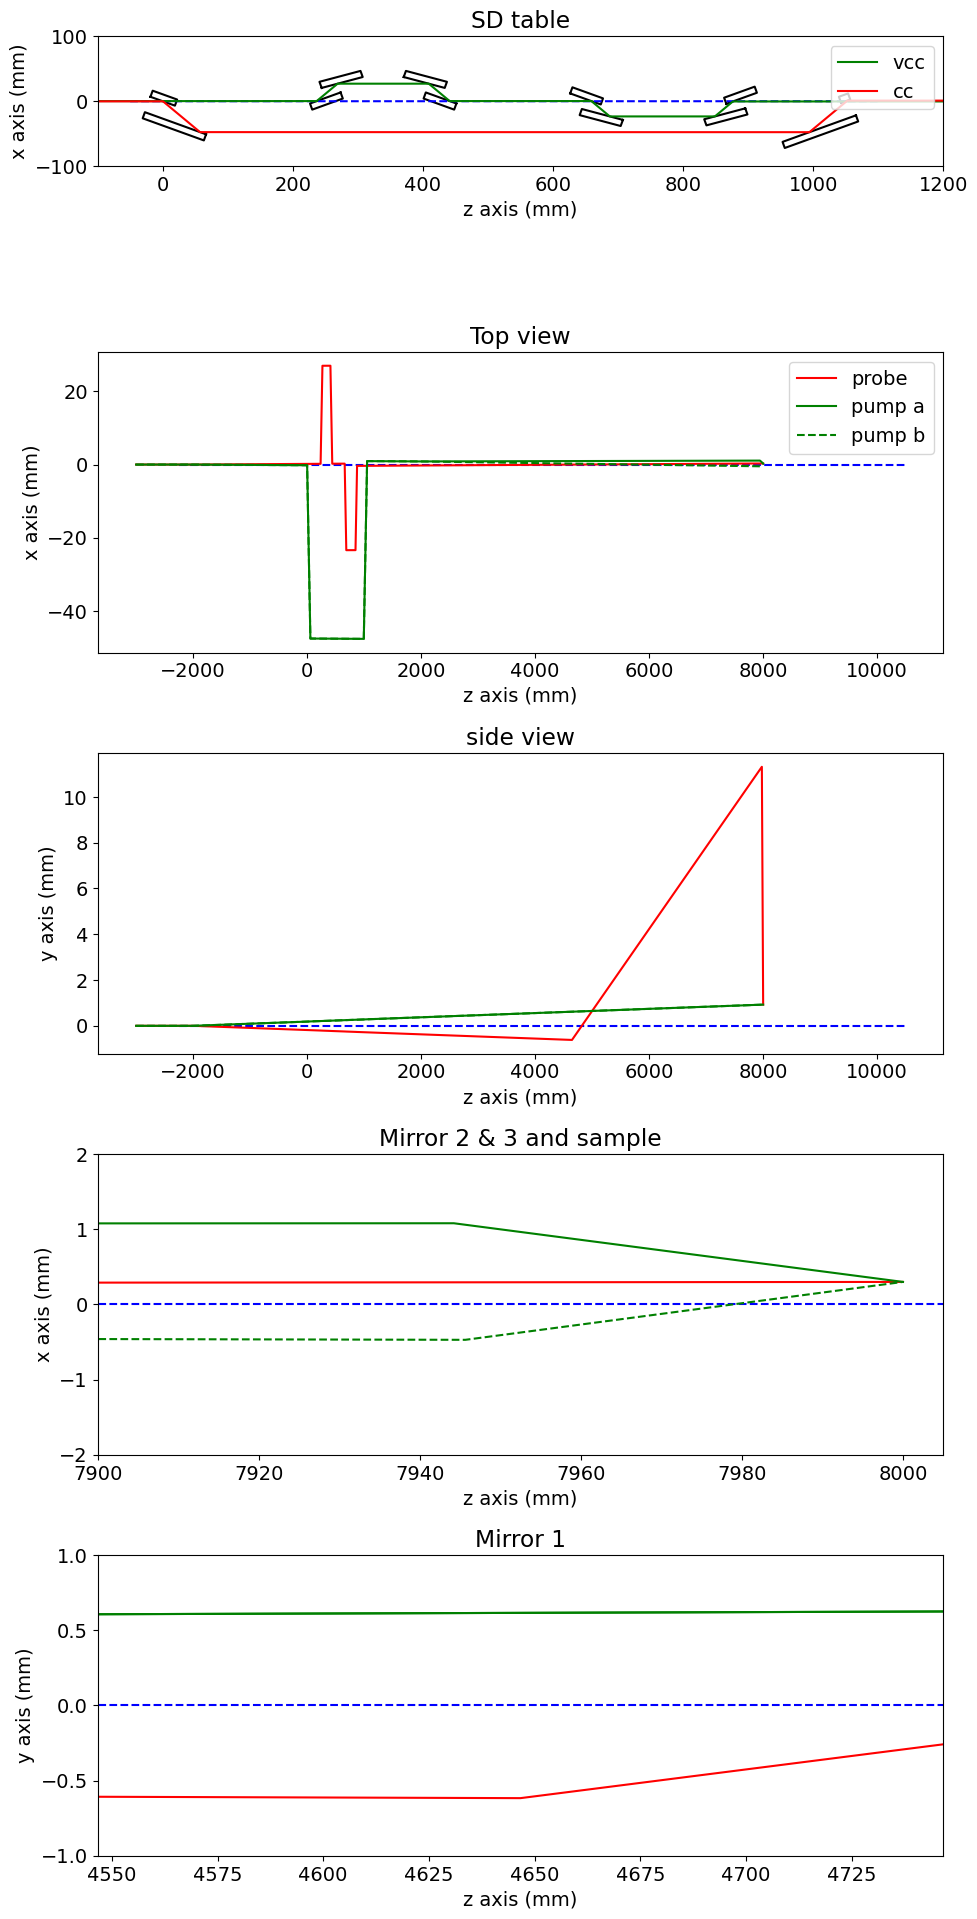

In [24]:
fig, axes = plt.subplots(ncols=1, nrows=5)

fig.set_figheight(20)
fig.set_figwidth(10)

# --------------------------------------------------------------------------
# Show the trajectory of the miniSD region
cmap = colormaps.get_cmap('spring')
for x in range(4):
    for idx in range(2):
        axes[0].plot(expSimu['devices']['vcc'][x].crystal_list[idx].boundary[:, 2] / 1000,
                     expSimu['devices']['vcc'][x].crystal_list[idx].boundary[:, 1] / 1000,
                     c='k')
        #c=cmap((x * 2 + idx) / 8))

for x in range(2):
    for idx in range(2):
        axes[0].plot(expSimu['devices']['cc'][x].crystal_list[idx].boundary[:, 2] / 1000,
                     expSimu['devices']['cc'][x].crystal_list[idx].boundary[:, 1] / 1000,
                     c='k')

# Plot a horizontal reference line
axes[0].plot(np.arange(-50, 1100), np.zeros(1150), c='b', linestyle='--')

# Plot the miniSD trajectory
axes[0].plot(expSimu['vcc']['trajectory'][:, 2] / 1000,
             expSimu['vcc']['trajectory'][:, 1] / 1000, 'g', label='vcc')

axes[0].plot(expSimu['cc']['trajectory'][:, 2] / 1000,
             expSimu['cc']['trajectory'][:, 1] / 1000, 'r', label='cc')

axes[0].set_aspect("equal")
axes[0].set_ylim([-100, 100])
axes[0].set_xlim([-100, 1200])
axes[0].set_xlabel("z axis (mm)")
axes[0].set_ylabel("x axis (mm)")
axes[0].set_title('SD table')
axes[0].legend()

# --------------------------------------------------------------------------
# Show the TG part in the x-z plane

# Plot a horizontal reference line
axes[1].plot(np.arange(-50 - 100, 700) * 15, np.zeros(850) * 10, c='b', linestyle='--')

# Plot the miniSD trajectory
axes[1].plot(expSimu['TG probe']['trajectory'][:, 2] / 1000,
             expSimu['TG probe']['trajectory'][:, 1] / 1000, 'r', label='probe')

axes[1].plot(expSimu['TG pump a']['trajectory'][:, 2] / 1000,
             expSimu['TG pump a']['trajectory'][:, 1] / 1000, 'g', label='pump a')

axes[1].plot(expSimu['TG pump b']['trajectory'][:, 2] / 1000,
             expSimu['TG pump b']['trajectory'][:, 1] / 1000, 'g--', label='pump b')

axes[1].set_xlabel("z axis (mm)")
axes[1].set_ylabel("x axis (mm)")

axes[1].set_title('Top view')
axes[1].legend()

# --------------------------------------------------------------------------
# Show the TG part in the y-z plane

# Plot a horizontal reference line
axes[2].plot(np.arange(-50 - 100, 700) * 15, np.zeros(850) * 10, c='b', linestyle='--')

# Plot the miniSD trajectory
axes[2].plot(expSimu['TG probe']['trajectory'][:, 2] / 1000,
             expSimu['TG probe']['trajectory'][:, 0] / 1000, 'r', label='probe')

axes[2].plot(expSimu['TG pump a']['trajectory'][:, 2] / 1000,
             expSimu['TG pump a']['trajectory'][:, 0] / 1000, 'g', label='pump a')

axes[2].plot(expSimu['TG pump b']['trajectory'][:, 2] / 1000,
             expSimu['TG pump b']['trajectory'][:, 0] / 1000, 'g--', label='pump b')

axes[2].set_xlabel("z axis (mm)")
axes[2].set_ylabel("y axis (mm)")
axes[2].set_title('side view')

# --------------------------------------------------
#   Sample region
# Plot a horizontal reference line
axes[3].plot(np.arange(-50 - 100, 700) * 15, np.zeros(850) * 10, c='b', linestyle='--')

# Plot the miniSD trajectory
axes[3].plot(expSimu['TG probe']['trajectory'][:, 2] / 1000,
             expSimu['TG probe']['trajectory'][:, 1] / 1000, 'r', label='probe')

axes[3].plot(expSimu['TG pump a']['trajectory'][:, 2] / 1000,
             expSimu['TG pump a']['trajectory'][:, 1] / 1000, 'g', label='pump a')

axes[3].plot(expSimu['TG pump b']['trajectory'][:, 2] / 1000,
             expSimu['TG pump b']['trajectory'][:, 1] / 1000, 'g--', label='pump b')

axes[3].set_xlabel("z axis (mm)")
axes[3].set_ylabel("x axis (mm)")
axes[3].set_xlim([8e3 - 100, 8e3 + 5])
axes[3].set_ylim([-2, 2])

axes[3].set_title('Mirror 2 & 3 and sample')

# --------------------------------------------------------------------------
# Zoom in to the sample region

# Plot a horizontal reference line
axes[4].plot(np.arange(-50 - 100, 700) * 15, np.zeros(850) * 10, c='b', linestyle='--')

# Plot the miniSD trajectory
axes[4].plot(expSimu['TG probe']['trajectory'][:, 2] / 1000,
             expSimu['TG probe']['trajectory'][:, 0] / 1000, 'r')

axes[4].plot(expSimu['TG pump a']['trajectory'][:, 2] / 1000,
             expSimu['TG pump a']['trajectory'][:, 0] / 1000, 'g')

axes[4].plot(expSimu['TG pump b']['trajectory'][:, 2] / 1000,
             expSimu['TG pump b']['trajectory'][:, 0] / 1000, 'g')

axes[4].set_xlabel("z axis (mm)")
axes[4].set_ylabel("y axis (mm)")
axes[4].set_title('Mirror 1')
axes[4].set_ylim([-1, 1])
axes[4].set_xlim([expSimu['TG probe']['trajectory'][-3][2] / 1000 - 100,
                  expSimu['TG probe']['trajectory'][-3][2] / 1000 + 100])

plt.tight_layout()
plt.show()

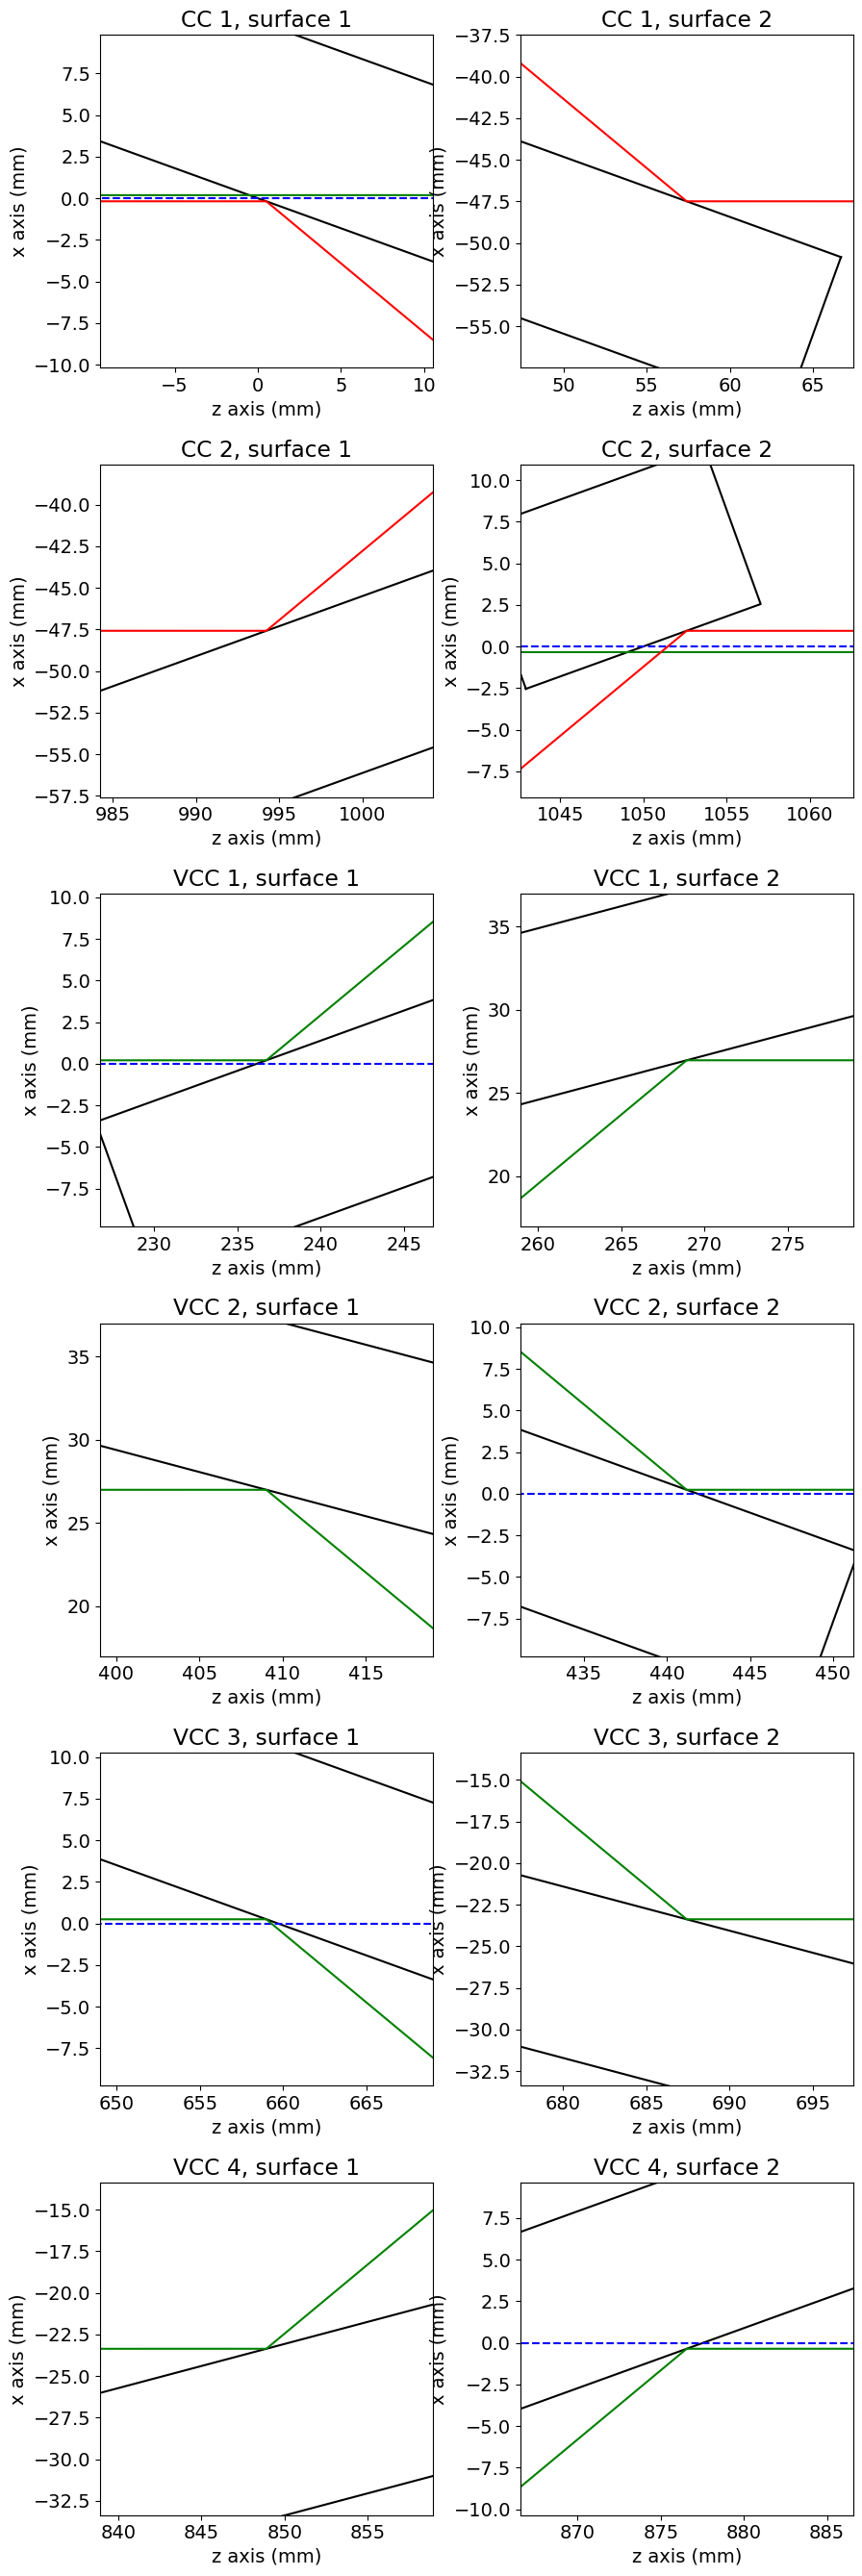

In [25]:
#############################################
#  The intersection point on the lower branch
#############################################
fig, axes = plt.subplots(6, 2)
fig.set_figheight(27)
fig.set_figwidth(9)

for n1 in range(2):
    for n2 in range(2):
        ax = axes[n1, n2]

        for x in range(4):
            for idx in range(2):
                ax.plot(expSimu['devices']['vcc'][x].crystal_list[idx].boundary[:, 2] / 1000,
                        expSimu['devices']['vcc'][x].crystal_list[idx].boundary[:, 1] / 1000,
                        c='k')

        for x in range(2):
            for idx in range(2):
                ax.plot(expSimu['devices']['cc'][x].crystal_list[idx].boundary[:, 2] / 1000,
                        expSimu['devices']['cc'][x].crystal_list[idx].boundary[:, 1] / 1000,
                        c='k')

        # Plot a horizontal reference line
        ax.plot(np.arange(-50, 1100), np.zeros(1150), c='b', linestyle='--')

        # Plot the miniSD trajectory
        ax.plot(expSimu['vcc']['trajectory'][:, 2] / 1000,
                expSimu['vcc']['trajectory'][:, 1] / 1000, 'g')

        ax.plot(expSimu['cc']['trajectory'][:, 2] / 1000,
                expSimu['cc']['trajectory'][:, 1] / 1000, 'r')

        ax.set_aspect("equal")
        ax.set_xlabel("z axis (mm)")
        ax.set_ylabel("x axis (mm)")

        idx = 2 * n1 + n2 + 2
        ax.set_xlim([expSimu['cc']['trajectory'][idx, 2] / 1000 - 10, expSimu['cc']['trajectory'][idx, 2] / 1000 + 10])
        ax.set_ylim([expSimu['cc']['trajectory'][idx, 1] / 1000 - 10, expSimu['cc']['trajectory'][idx, 1] / 1000 + 10])

        ax.set_title("CC {}, surface {}".format(n1 + 1, n2 + 1))

for n1 in range(2, 6):
    for n2 in range(2):
        ax = axes[n1, n2]

        for x in range(4):
            for idx in range(2):
                ax.plot(expSimu['devices']['vcc'][x].crystal_list[idx].boundary[:, 2] / 1000,
                        expSimu['devices']['vcc'][x].crystal_list[idx].boundary[:, 1] / 1000,
                        c='k')

        for x in range(2):
            for idx in range(2):
                ax.plot(expSimu['devices']['cc'][x].crystal_list[idx].boundary[:, 2] / 1000,
                        expSimu['devices']['cc'][x].crystal_list[idx].boundary[:, 1] / 1000,
                        c='k')

        # Plot a horizontal reference line
        ax.plot(np.arange(-50, 1100), np.zeros(1150), c='b', linestyle='--')

        # Plot the miniSD trajectory
        ax.plot(expSimu['vcc']['trajectory'][:, 2] / 1000,
                expSimu['vcc']['trajectory'][:, 1] / 1000, 'g')

        ax.plot(expSimu['cc']['trajectory'][:, 2] / 1000,
                expSimu['cc']['trajectory'][:, 1] / 1000, 'r')

        ax.set_aspect("equal")
        ax.set_xlabel("z axis (mm)")
        ax.set_ylabel("x axis (mm)")

        idx = 2 * (n1 - 2) + n2 + 2
        ax.set_xlim(
            [expSimu['vcc']['trajectory'][idx, 2] / 1000 - 10, expSimu['vcc']['trajectory'][idx, 2] / 1000 + 10])
        ax.set_ylim(
            [expSimu['vcc']['trajectory'][idx, 1] / 1000 - 10, expSimu['vcc']['trajectory'][idx, 1] / 1000 + 10])

        ax.set_title("VCC {}, surface {}".format(n1 - 1, n2 + 1))

plt.tight_layout()
plt.show()

# Adjust the horizontal relative positions between the two TG branches

In [8]:
# Get current horizontal separation
pump_0 = expSimu['TG pump 0']['trajectory'][-1]
pump_a = expSimu['TG pump a']['trajectory'][-1]
pump_b = expSimu['TG pump b']['trajectory'][-1]

move_a = (pump_0[1] - pump_a[1]) / pump1z_coef['pump a']['position'][1]
move_b = (pump_0[1] - pump_b[1]) / pump2z_coef['pump b']['position'][1]

print("To make the two TG pulse overlap with the 0th order")
print("mirror-a move {:.2f}".format(move_a))
print("mirror-b move {:.2f}".format(move_b))

To make the two TG pulse overlap with the 0th order
mirror-a move 0.00
mirror-b move 0.00


# Adjust the silicon crystal position such that the vertical position overlap

In [9]:
probe = expSimu['TG probe']['trajectory'][-1]

move_si = (pump_0[0] - probe[0]) / probe2z_coef['probe']['position'][0]

print("To make the probe pulse overlap vertically with the pump pulse")
print("Move silicon 111 by {:.2f}".format(move_si))

To make the probe pulse overlap vertically with the pump pulse
Move silicon 111 by 0.88


# Adjust the VCC branch such that pump and probe overlap in space

In [10]:
move_t4_t5 = (pump_a[1] - probe[1]) / t4x_coef['probe']['position'][1] / 2
print("To make the probe pulse overlap horizontally with the pump pulse")
print("Move t4x positive and t5x negative by {:.2f}".format(move_t4_t5))

To make the probe pulse overlap horizontally with the pump pulse
Move t4x positive and t5x negative by 0.06


# Calculate the current path length difference

In [11]:
pathdiff_probe_a = (expSimu['TG probe']['pathLength'] - expSimu['TG pump a']['pathLength']) / util.c / 1000
print("Probe arrives {:.2f} ps later than pump a".format(pathdiff_probe_a))

pathdiff_probe_b = (expSimu['TG probe']['pathLength'] - expSimu['TG pump b']['pathLength']) / util.c / 1000
print("Probe arrives {:.2f} ps later than pump b".format(pathdiff_probe_b))


Probe arrives 12.81 ps later than pump a
Probe arrives 12.81 ps later than pump b


# Get the spatial seapration of the pulses at the first edge of CC1

In [12]:
# Get the spatial separation of the two pulses at the first edge of CC1
pulse1_loc = expSimu['vcc']['kout'][1] / np.linalg.norm(expSimu['vcc']['kout'][1]) * 2e6
pulse2_loc = expSimu['cc']['kout'][1] / np.linalg.norm(expSimu['cc']['kout'][1]) * 2e6
print("Spatial separation at the first edge of CC1")
print(pulse2_loc - pulse1_loc)

Spatial separation at the first edge of CC1
[ 369.13711994 -369.13711994    0.        ]


# Get the separation between the sample and the total reflection mirrors for the TG

In [13]:
separation = expSimu['TG pump a']['trajectory'][-1] - expSimu['TG pump a']['trajectory'][-2]
print('separation in mm', separation / 1e3)

separation in mm [ 5.14750989e-03 -7.80926148e-01  5.57733706e+01]


# The spatial separation between different pulses

In [14]:
print(probe)
print(pump_a)
print(pump_b)

[9.25637676e+02 2.99691643e+02 8.00000000e+06]
[9.26039314e+02 2.99773665e+02 8.00000000e+06]
[9.26039314e+02 2.99773746e+02 8.00000000e+06]


In [15]:
300 / np.sin(np.deg2rad(0.1)) / 1e3 / 10

17.188742580574058

In [19]:
expSimu['TG pump a']['trajectory'][-1]

array([9.26039314e+02, 2.99773665e+02, 8.00000000e+06])

In [21]:
expSimu['TG pump a']['trajectory'][-2]

array([9.20891804e+02, 1.08069981e+03, 7.94422663e+06])

In [23]:
(8.00000000e+06 -  7.94422663e+06) / 1e4

5.5773370000000115